##Depemdencies

In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 15.5 MB/s 
     |████████████████████████████████| 895 kB 59.4 MB/s 
     |████████████████████████████████| 3.3 MB 61.9 MB/s 
     |████████████████████████████████| 636 kB 72.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
punctuation = string.punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import keras
from keras.preprocessing import sequence, text
from keras.layers import Input, Embedding
from string import punctuation
import string
punctuation = string.punctuation
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
stop_words = list(set(stopwords.words('english')))
from sklearn.model_selection import train_test_split
import spacy
from tqdm import tqdm
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
# from skmultilearn.problem_transform import ClassifierChain
# from skmultilearn.problem_transform import LabelPowerset

from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from scipy import sparse
from datetime import datetime
from sklearn.metrics import confusion_matrix,r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import coo_matrix, hstack, csr_matrix
import pickle
from gensim.models import KeyedVectors
from gensim.models.fasttext import FastText
from tqdm import tqdm
from transformers import MT5Model, MT5Tokenizer
from transformers import DistilBertConfig, DistilBertTokenizer, TFDistilBertModel
from transformers import pipeline
from transformers import DistilBertModel, DistilBertConfig
from tqdm import tqdm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##loading data

In [3]:
data=pd.read_csv('/content/all_tickets.csv')
data.drop_duplicates(inplace = True) # Removing Duplicates
print(data.shape)

(48549, 9)


In [4]:
data.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


##Basic data analysis

In [6]:
data.isna().sum()

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64

We will be prediction the category 

In [7]:
data.category.value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [8]:
data.ticket_type.value_counts()

1    34621
0    13928
Name: ticket_type, dtype: int64

In [5]:
data.business_service.value_counts()

32    8174
36    3685
68    3589
67    2858
4     2527
      ... 
37       1
69       1
81       1
17       1
0        1
Name: business_service, Length: 103, dtype: int64

In [6]:
data.urgency.value_counts()

3    34621
1     6748
2     5528
0     1652
Name: urgency, dtype: int64

In [7]:
data.impact.value_counts()

4    34621
3    13184
0      471
2      228
1       45
Name: impact, dtype: int64

We can see that the data is heavently imbalanced in almost all categories,

We can go with the prediction of the ticket type which is least imbalanced 

Lets see the datapoint distrubution of ticket category

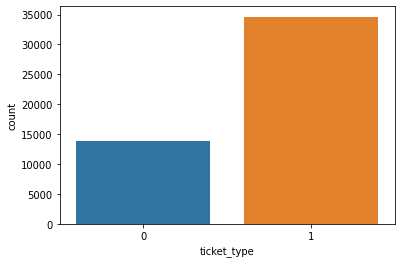

In [ ]:
sns.countplot(data=data,x='ticket_type')
plt.show()

In [ ]:
print('{0} percentage of ticket type is 0'.format(round(data.ticket_type.value_counts()[0]/(len(data.ticket_type))*100,2)))

28.69 percentage of ticket type is 0


##Feature Engg

We can drop the NA cases as they are fairly low in number

In [4]:
data.dropna(inplace=True)

merging all the columns as one

In [5]:
data['all'] = data[['title', 'body']].apply(lambda x: ' '.join(x), axis=1)

Lets create some features for the data set

Totle word count

In [6]:
data['title_count']=data['title'].apply(lambda x: len([w for w in x.split() if w.isalnum()==True]))
data['body_count']=data['body'].apply(lambda x: len([w for w in x.split() if w.isalnum()==True]))

In [7]:
data.head(2)

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,all,title_count,body_count
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4,connection with icon icon dear please setup ic...,3,15
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4,work experience user work experience user hi w...,3,16


In [8]:
data.drop(columns=['body','title'],inplace=True)

In [9]:
data['length']=data['all'].apply(lambda x: len(x))

In [10]:
data = data[data.length > 2]

In [11]:
data.columns

Index(['ticket_type', 'category', 'sub_category1', 'sub_category2',
       'business_service', 'urgency', 'impact', 'all', 'title_count',
       'body_count', 'length'],
      dtype='object')

###Wordcloud Text Data

Leta look at the word cloud distrubution of one of the most used words,
of unigram distrubtion

In [16]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud(data, column):  # ref: https://www.geeksforgeeks.org/generating-word-cloud-python/
    comment_words = ''
    stopwords = set(STOPWORDS)

    for val in data[column]:	
	# typecaste each val to string
	    val = str(val)
	# split the value
	    tokens = val.split()	
	# Converts each token into lowercase
	    for i in range(len(tokens)):
		    tokens[i] = tokens[i].lower()	
	    comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 500, height = 300,
				background_color ='black',
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words)
    # plot the WordCloud image					
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

When ticket type is 1

In [17]:
df_1=data[data['ticket_type']==1]

In [18]:
df_1.head(3)

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,all
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4,connection with icon icon dear please setup ic...
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4,work experience user work experience user hi w...
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4,requesting for meeting requesting meeting hi p...


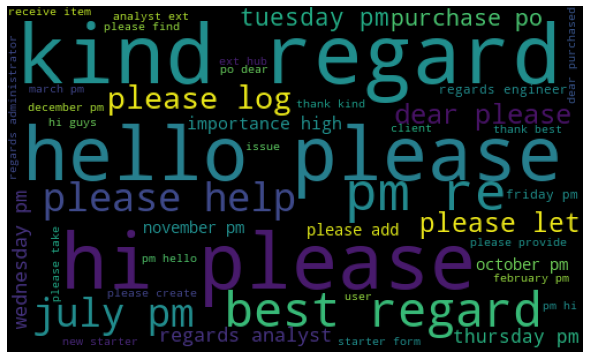

In [19]:
word_cloud(df_1, 'all')

When ticket type is 0

In [20]:
df_0=data[data['ticket_type']==0]

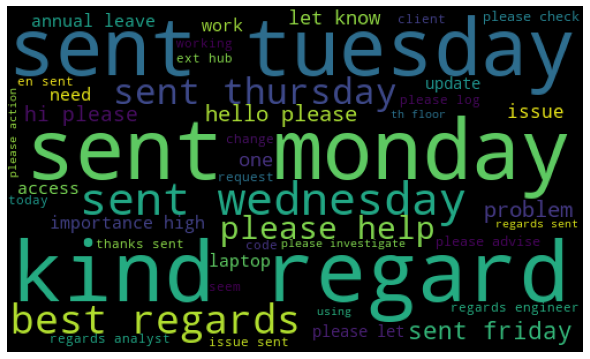

In [21]:
word_cloud(df_0, 'all')

Text preprocessing

In [7]:
# preprocessing 

import re
from nltk.stem import WordNetLemmatizer  # lemmatizer
stemmer = WordNetLemmatizer()

def preprocess(text):
    
    text = re.sub(r"won\'t", "will not", text)   # decontracting the words
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r'\W', ' ', str(text))  # Remove all the special characters

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # remove all single characters 
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # replace all the words except "A-Za-z_" with space

    text = re.sub(r'[^\w\s]','',text)

    text = ' '.join(e for e in text.split() if e.lower() not in stopwords.words('english') and len(e)>2)  # convert to lower and remove stopwords discard words whose len < 2
    
    text = text.lower().strip()   # strip

    # Lemmatization
    tokens = text.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 2]

    new_text = ' '.join(tokens)

    return new_text

In [8]:
data['all']= data['all'].apply(lambda x: preprocess(x))

##Train Test Split

In [12]:
data_x=data.drop(columns=['ticket_type'])
data_y=data['ticket_type']

In [13]:
train_x,test_x,train_y,test_y=train_test_split(data_x,data_y,stratify=data_y,test_size=0.2,random_state=42)

In [17]:
print(train_x.shape)
print(test_x.shape)

(38269, 10)
(9568, 10)


In [ ]:
# train_x.drop(['target'],axis=1,inplace=True)

##EDA

Numerical data analysis

In [36]:
train_x.dtypes

category             int64
sub_category1        int64
sub_category2        int64
business_service     int64
urgency              int64
impact               int64
all                 object
title_count          int64
body_count           int64
length               int64
dtype: object

Lets do some feature analysis of umerical attributes

In [39]:
train_x['target']=train_y

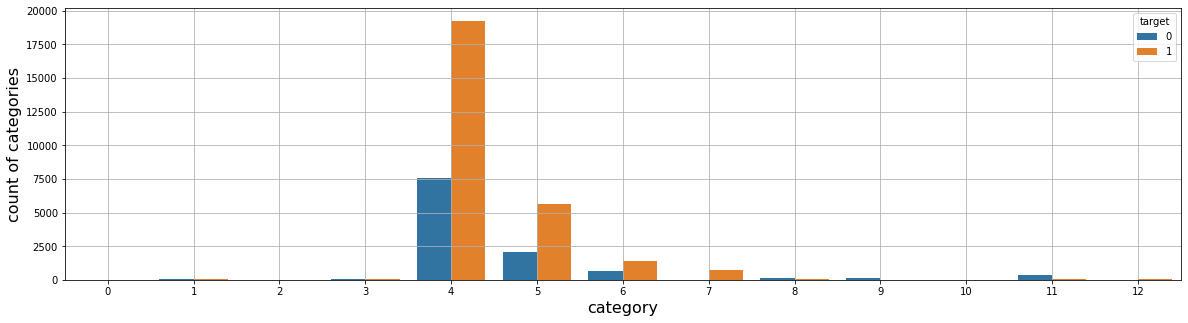

4     26801
5      7647
6      2076
7       733
11      466
8       185
9       150
3       112
1        57
12       33
2         3
0         3
10        2
Name: category, dtype: int64

In [27]:
#category
plt.figure(figsize=(20,5))
sns.countplot(data=train_x,x='category',hue='target')
plt.xlabel("category", size=16)
plt.ylabel("count of categories", size=16)
plt.grid()
plt.show()

train_x.category.value_counts()

In [ ]:
print('{0} percentage of ticket type is category 4'.format(round(train_x.category.value_counts()[4]/(len(train_x))*100,2)))

70.1 percentage of ticket type is category 4


Maximum data belog to one category only 4

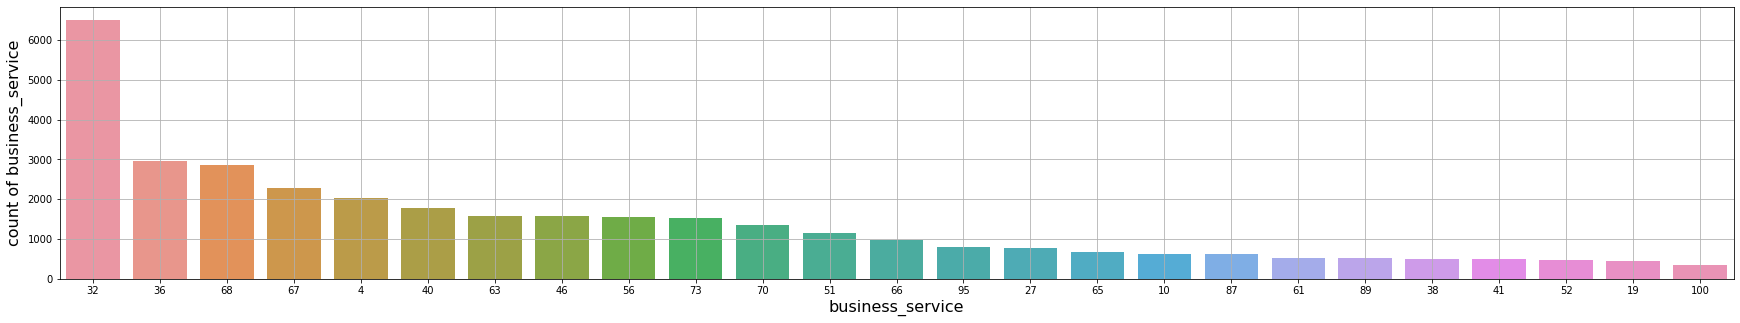

In [ ]:
#business_service
plt.figure(figsize=(30,5))
sns.countplot(data=train_x,x='business_service',order=train_x.business_service.value_counts().iloc[:25].index)
plt.xlabel("business_service", size=16)
plt.ylabel("count of business_service", size=16)
plt.grid()
plt.show()

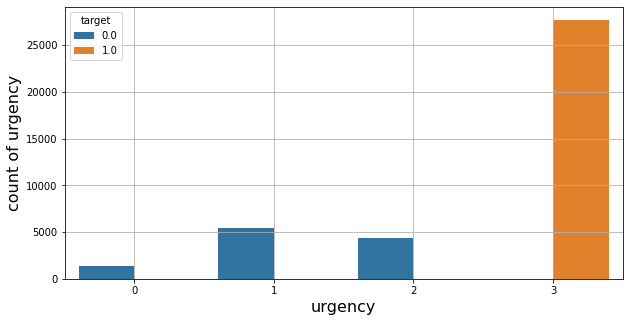

3    27693
1     5392
2     4403
0     1346
Name: urgency, dtype: int64

In [ ]:

#urgency
plt.figure(figsize=(10,5))
sns.countplot(data=train_x,x='urgency',hue='target')
plt.xlabel("urgency", size=16)
plt.ylabel("count of urgency", size=16)
plt.grid()
plt.show()

train_x.urgency.value_counts()

Urgencey 0,1,2 are 0 and 3 is 1 this is very stange

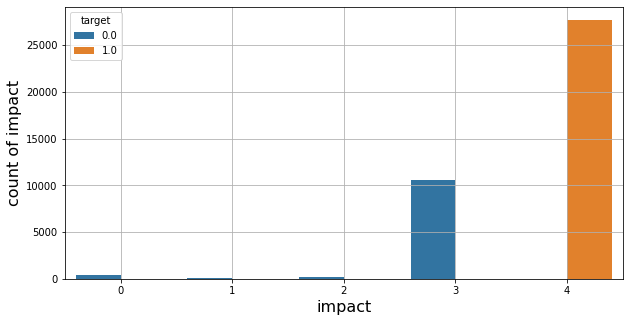

4    27693
3    10567
0      367
2      173
1       34
Name: impact, dtype: int64

In [ ]:
#impact
plt.figure(figsize=(10,5))
sns.countplot(data=train_x,x='impact',hue='target')
plt.xlabel("impact", size=16)
plt.ylabel("count of impact", size=16)
plt.grid()
plt.show()

train_x.impact.value_counts()

The distrubution is majorly same as urgency 

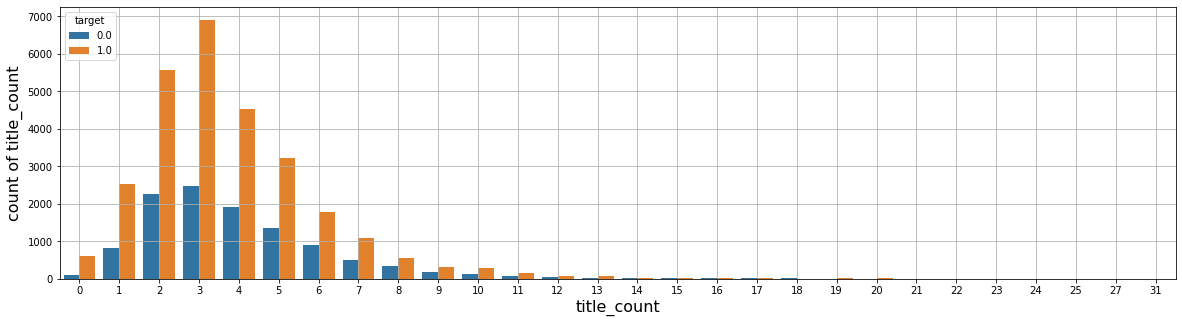

3    9377
2    7818
4    6439
5    4573
1    3339
6    2660
7    1582
8     901
0     697
9     497
Name: title_count, dtype: int64

In [ ]:

#title_count
plt.figure(figsize=(20,5))
sns.countplot(data=train_x,x='title_count',hue='target')
plt.xlabel("title_count", size=16)
plt.ylabel("count of title_count", size=16)
plt.grid()
plt.show()

train_x.title_count.value_counts()[:10]

Title is majorly no more than 3-5 word count

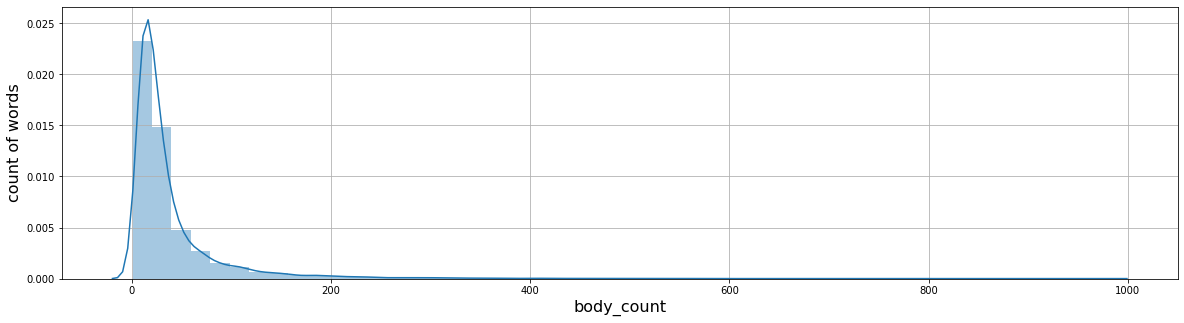

14    1338
12    1314
13    1296
11    1276
15    1218
16    1203
17    1184
10    1181
9     1095
18    1043
Name: body_count, dtype: int64

In [ ]:
#body_count
plt.figure(figsize=(20,5))
sns.distplot(train_x['body_count'])
plt.xlabel("body_count", size=16)
plt.ylabel("count of words", size=16)
plt.grid()
plt.show()
train_x.body_count.value_counts()[:10]

Maximum words are under 150 words 

Lets plot the CDF plot

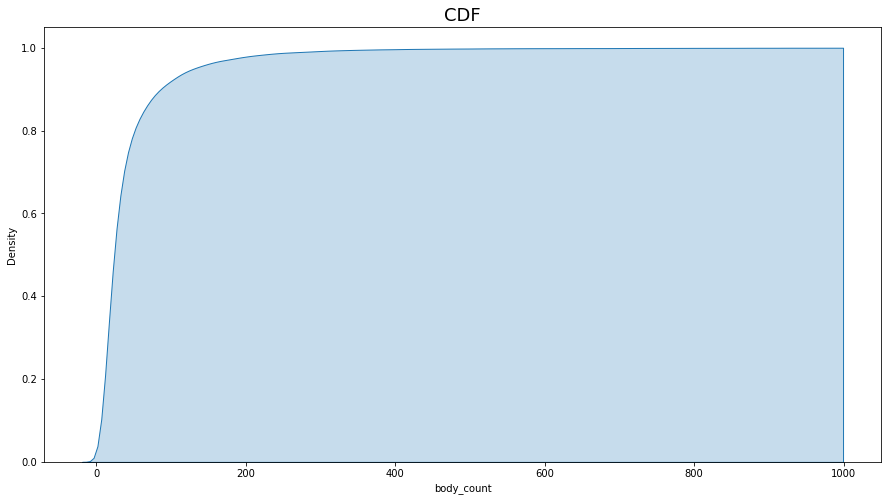

In [ ]:
plt.figure(figsize=(15,8))
sns.kdeplot(train_x['body_count'], shade=True, cumulative=True)
plt.title('CDF',size = 18)
plt.show()

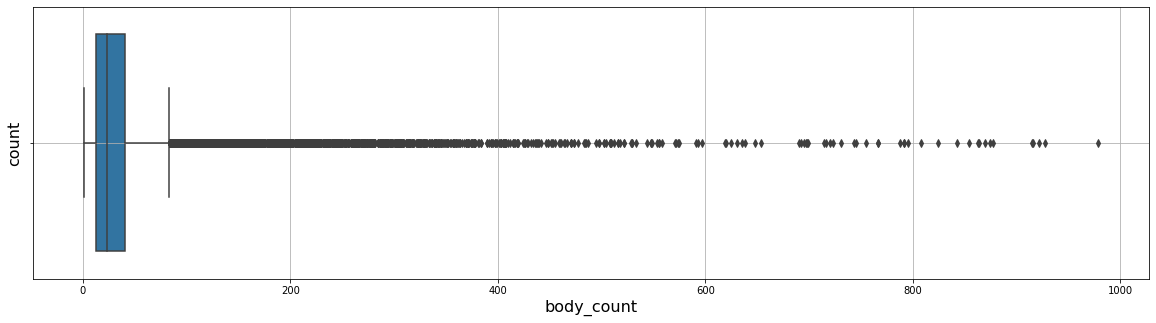

In [ ]:
#train_x['body_count']
plt.figure(figsize=(20,5))
sns.boxplot(data=train_x,x='body_count')
plt.xlabel("body_count", size=16)
plt.ylabel("count", size=16)
plt.grid()
plt.show()

Lets see the correlation matrix 

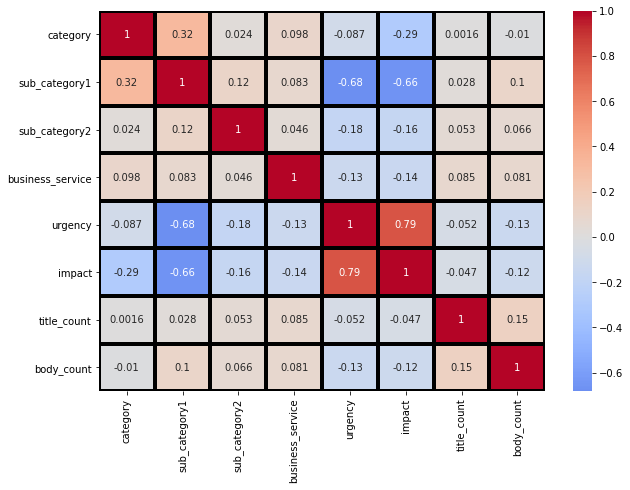

In [ ]:
#coorilation between numerical features
plt.figure(figsize=(10,7))
sns.heatmap(train_x[num_attrib].corr(), annot = True, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

##Normalizing Numerical Data

lets standardize the numerical data for the modelling

In [14]:
num_attrib=['category','sub_category1','sub_category2','business_service','urgency','impact','title_count','body_count','length']

In [20]:
#minmaxing the numerical attributes
minmax_scalar = MinMaxScaler()
train_num_feat = minmax_scalar.fit_transform(train_x[num_attrib])
test_num_feat=minmax_scalar.transform(test_x[num_attrib])

file_n = open('/content/drive/MyDrive/dataset_link/minmax_scale_cs2_new_07.pkl', 'wb')

# dump information to that file
pickle.dump(minmax_scalar, file_n)
file_n.close()

##Vectorizing Types 

Lets start with the word embedding

We will use 3 models for the woed embedding:

1 Word2Vec

2 Fast Text

3 BERT

4 TFIDF

###W2Vec Model

In [15]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-08-06 03:12:42--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.73.10
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.73.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  34.2MB/s    in 47s     

2021-08-06 03:13:30 (33.2 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [16]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [17]:
def w2v(X):
    words=list(word2vec.vocab)
    x = []
    for sentence in tqdm(X): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        for word in sentence.split(): # for each word in a review/sentence
            if word in words:
                vector += word2vec[word]
        x.append(vector)
    x = np.array(x)
    return x

###fast text 300d

In [18]:
!wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://fasttext.cc/" "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip" -c -O 'wiki-news-300d-1M.vec.zip'

--2021-08-06 03:15:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  11.8MB/s    in 58s     

2021-08-06 03:16:28 (11.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [19]:
! unzip /content/wiki-news-300d-1M.vec.zip

Archive:  /content/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [20]:
model_ft = KeyedVectors.load_word2vec_format('/content/wiki-news-300d-1M.vec')

In [21]:
def fast_text_embed(X):
    words=list(model_ft.vocab)
    x = []
    for sentence in tqdm(X): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        for word in sentence.split(): # for each word in a review/sentence
            if word in words:
                vector += model_ft[word]
        x.append(vector)
    x = np.array(x)
    return x

###Bert embedding

1- The config contains the settings for bert, the config tunes the selected bert type in our case it is distilbert-bert-uncased, you can see we have mentioned in the config that we want the configuration of distilbert-bert-uncased and enabled hidden states to return which tunes the bert to return layers output in our bert.


2- The model as name suggest it makes our model based on the settings we made in the config. Additional, it downloads the required weights ,implement the tokenizer, padding and masking.


3- The pipeline makes our life easier it flows the  codes in sequential methods as required by the bert and it takes task for which we are making to save us from complex coding and makes us less prone to mistakes. The pipeline can take many tasks/commands like NER, Sentiment Analysis, Feature Extraction and Question Answering, etc

In [22]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Loading Tokenizer

# Initializing a DistilBERT configuration
configuration = DistilBertConfig.from_pretrained('distilbert-base-uncased', output_hidden_states = True)

# Initializing a model from the configuration
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = configuration)

# Accessing the model configuration

nlp = pipeline('feature-extraction', model = model, tokenizer = tokenizer, framework = "tf") # Defining Pipling as Feature-Extractor
def convertion(string):
    inputs = tokenizer(string, return_tensors = "tf")
    outputs = model(inputs)
    outputs = np.concatenate((outputs[1][6][0,0,:],outputs[1][5][0,0,:],outputs[1][4][0,0,:],outputs[1][3][0,0,:]), axis=0) # Concatinating Only 3,4,5,6 layer of BERT
    return np.array(outputs)

def convertor(X):
    sent =[]
    vec=[]
    for i in tqdm(X,position=0, leave=True):
        text = i[:512]
        vec.append(convertion(text))
    return vec

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


###TFIDF

In [29]:
data_text=train_x['all']

In [30]:
#tfidf
tfidf = TfidfVectorizer()
tfidf.fit_transform(data_text)
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

Lers start the modelling part and see which performs the best

##Utility Function

In [34]:
#utility function

def resultant(y_true, y_pred,model,vect):

  val_1=mean_absolute_error(y_true, y_pred)
  val_2=r2_score(y_true, y_pred)
  val_3=mean_squared_error(y_true, y_pred)
  print("*"*12,model,"*"*5,vect,"*"*12)
  print('Mean Absolute Error:{0}'.format(val_1))
  print('R Square: {0}'.format(val_2))
  print("Recall: ", recall_score(y_true, y_pred))
  print("Precision: ", precision_score(y_true, y_pred))
  print("Fl score: ", f1_score(y_true, y_pred))
  # print('Best Estimators are',clf)
  print("=="*30,'\n')

  conf = confusion_matrix(y_true, y_pred).round(3)
  plt.figure(figsize=(9,6))
  sns.heatmap(conf, annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black')
  
  plt.title("Confusion Matrix",fontsize=20)
  plt.xlabel("Predicted Value",fontsize=16)
  plt.ylabel("True Value",fontsize=16)


##Modelling Data

###Vectors selection

In [24]:
def vect_models(train_x, test_x, vectorizor_mode):

        if vectorizor_mode.lower() == 'tfidf':

            model=pickle.load(open('/content/tfidf.pkl','rb'))
            train_x = model.transform(train_x)
            test_x = model.transform(test_x)
            return train_x.todense(),test_x.todense()

        if vectorizor_mode.lower() == 'w2v':

            train_x = w2v(train_x)
            test_x = w2v(test_x)
            return train_x,test_x

        if vectorizor_mode.lower() == 'fast':

            train_x = fast_text_embed(train_x)
            test_x = fast_text_embed(test_x)
            return train_x,test_x

        if vectorizor_mode.lower() == 'bert':

            train_x = np.array(convertor(train_x))
            test_x = np.array(convertor(test_x)) 
            return train_x,test_x
            
        

###Model Selection

In [25]:
def knn_model(X,y):
  knn = KNeighborsClassifier()
  k_range = list(range(1,3))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, scoring='accuracy')
  grid.fit(X, y)
  return grid.best_params_

def nb_model(X,y):
  gnb = GaussianNB()
  parameters = {'var_smoothing': [1e-11, 1e-10, 1e-9]}
  grid = GridSearchCV(gnb, parameters, n_jobs=-1, scoring='accuracy')
  grid.fit(X, y)
  return grid.best_params_

def rf_model(X,y):  
  rf=RandomForestClassifier()
  parameters = {
          'n_estimators': [10, 100, 1000],
          'max_features' : ['sqrt', 'log2']
          }
  grid = GridSearchCV(rf, parameters, scoring='accuracy')
  grid.fit(X, y)
  return grid.best_params_  

###Modelling

In [26]:
def mod_models(train_data, test_data,vectorizor_mode,model_mode):  
        train_x, train_y = train_data
        test_x, test_y = test_data

        num_attrib=['category','sub_category1','sub_category2','business_service','urgency','impact','title_count','body_count','length']
        
        train_num=train_x.filter(num_attrib)
        test_num=test_x.filter(num_attrib)
        model_num=pickle.load(open('/content/drive/MyDrive/dataset_link/minmax_scale_cs2_new_1.pkl','rb'))
        train_num=model_num.transform(train_num)
        test_num=model_num.transform(test_num)

        train_text=train_x['all']
        test_text=test_x['all']
        train_txt,test_txt =vect_models(train_text, test_text, vectorizor_mode)

        train_df=pd.concat([pd.DataFrame(train_txt), pd.DataFrame(train_num,columns=num_attrib)], axis=1)
        test_df=pd.concat([pd.DataFrame(test_txt), pd.DataFrame(test_num,columns=num_attrib)], axis=1)

        if model_mode.lower() == 'none':

          return train_df,test_df
        
        if model_mode.lower() == 'knn':
          
          clf=knn_model(train_df,train_y)
          my_model = KNeighborsClassifier(**clf)
          my_model.fit(train_df,train_y)

          # pickle.dump(my_model, open('knn'+'_'+vectorizor_mode+'_'+'.sav', 'wb'))

          predictions = my_model.predict(test_df)
          resultant(test_y, predictions,model="KNN Classifier",vect=vectorizor_mode)


        if model_mode.lower() == 'nb':
          
          clf=nb_model(train_df,train_y)
          my_model = GaussianNB(**clf)
          my_model.fit(train_df,train_y)

          # pickle.dump(my_model, open('nb'+'_'+vectorizor_mode+'_'+'.sav', 'wb'))

          predictions = my_model.predict(test_df)
          resultant(test_y, predictions,model="NB Classifier",vect=vectorizor_mode)

        if model_mode.lower() == 'rf':
          
          clf=rf_model(train_df,train_y)          
          my_model = RandomForestClassifier(**clf)
          my_model.fit(train_df,train_y)

          # pickle.dump(my_model, open('rf'+'_'+vectorizor_mode+'_'+'.sav', 'wb'))

          predictions = my_model.predict(test_df)
          resultant(test_y, predictions,model="RF Classifier",vect=vectorizor_mode,clf=clf)
      

##Sanity Check of dataset

As dataset is too large we will take a sample of dataset to find the best model and then train in that dataset the whole data

In [35]:
samp_train,samp_test,samp_train_y,samp_test_y=train_test_split(test_x,test_y,stratify=test_y,test_size=0.2,random_state=42)

###KNN-TFIDF

************ KNN Classifier ***** tfidf ************
Mean Absolute Error:0.01619644723092999
R Square: 0.9210799336014812
Recall:  0.986784140969163
Precision:  0.9904200442151806
Fl score:  0.9885987495402722



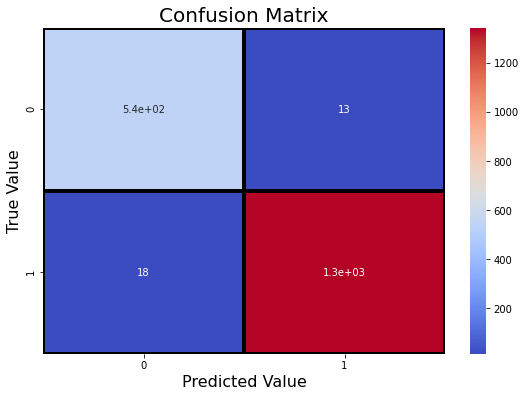

In [36]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'tfidf','knn')

###KNN-W2V

100%|██████████| 1914/1914 [01:40<00:00, 19.06it/s]


************ KNN Classifier ***** w2v ************
Mean Absolute Error:0.08672936259143156
R Square: 0.5773957734788994
Recall:  0.933920704845815
Precision:  0.9436201780415431
Fl score:  0.9387453874538746



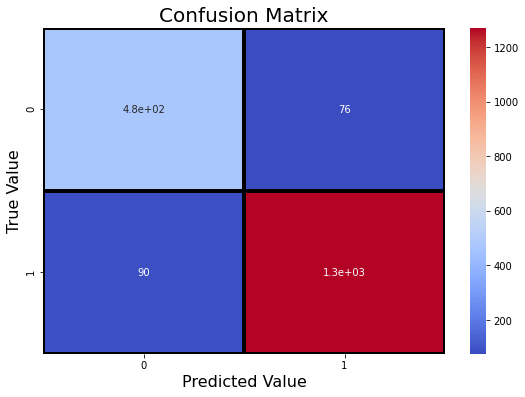

In [37]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'w2v','knn')

###KNN-FAST

100%|██████████| 1914/1914 [00:15<00:00, 124.31it/s]


********** KNN Classifier ***** fast **********
Mean Absolute Error:0.08463949843260188
R Square: 0.5875790078529017
Recall:  0.933920704845815
Precision:  0.9464285714285714
Fl score:  0.9401330376940134



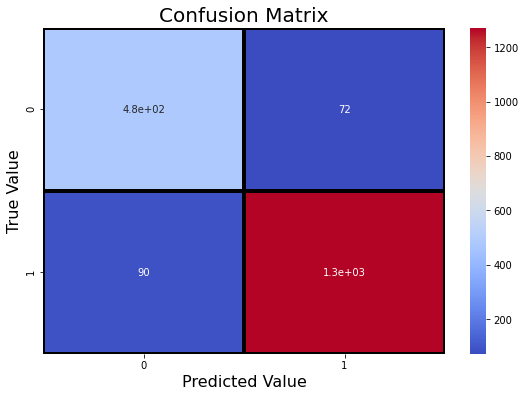

In [112]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'fast','knn')

###KNN-BERT

100%|██████████| 1914/1914 [02:06<00:00, 15.08it/s]


********** KNN Classifier ***** bert **********
Mean Absolute Error:0.07993730407523511
R Square: 0.6104912851944072
Recall:  0.9419970631424376
Precision:  0.9454679439941046
Fl score:  0.9437293122471496



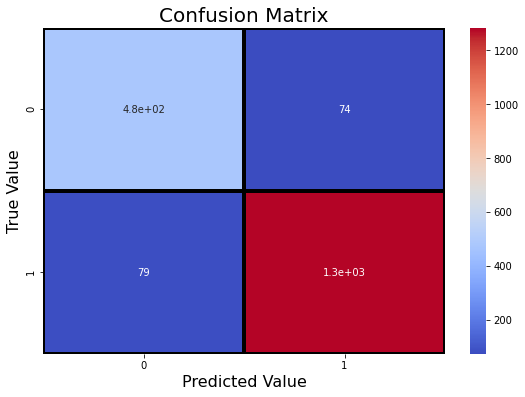

In [113]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'bert','knn')

###NAIVE BAYES-TFIDF

************ NB Classifier ***** tfidf ************
Mean Absolute Error:0.351619644723093
R Square: -0.7133291834259081
Recall:  0.5102790014684288
Precision:  0.9914407988587732
Fl score:  0.6737760542898692



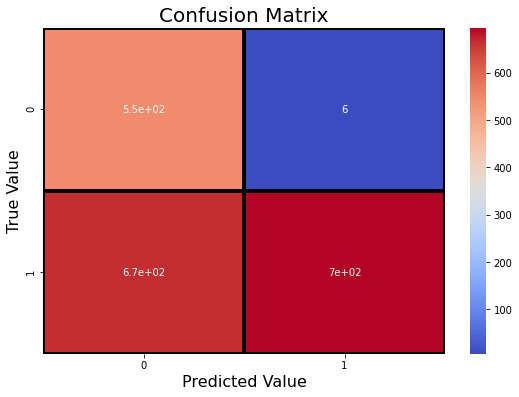

In [38]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'tfidf','nb')

###NAIVE BAYES-W2V

100%|██████████| 1914/1914 [01:36<00:00, 19.76it/s]


********** NB Classifier ***** w2v **********
Mean Absolute Error:0.06321839080459771
R Square: 0.6919571601864266
Recall:  0.9111600587371512
Precision:  1.0
Fl score:  0.9535151747983096



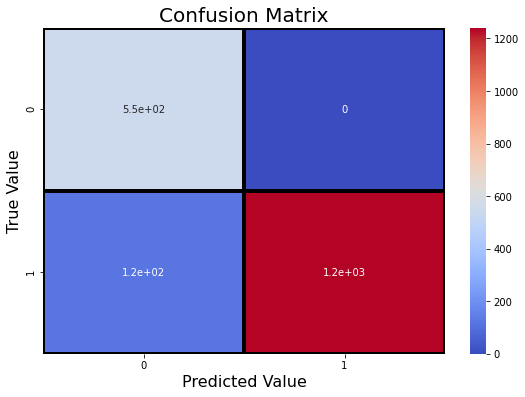

In [115]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'w2v','nb')

###NAIVE BAYES-FAST

100%|██████████| 1914/1914 [00:19<00:00, 99.97it/s] 


************ NB Classifier ***** fast ************
Mean Absolute Error:0.06269592476489028
R Square: 0.6945029687799272
Recall:  0.9118942731277533
Precision:  1.0
Fl score:  0.9539170506912442



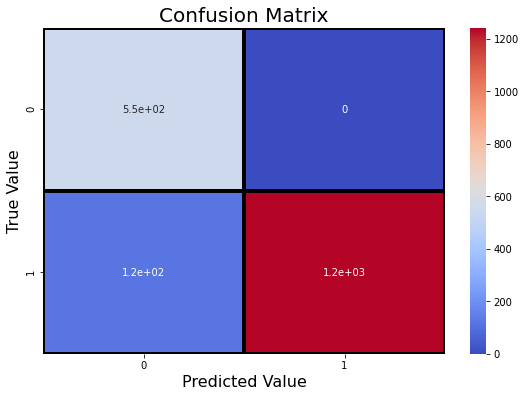

In [39]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'fast','nb')

###NAIVE BAYES-BERT

100%|██████████| 1914/1914 [02:23<00:00, 13.36it/s]


************ NB Classifier ***** bert ************
Mean Absolute Error:0.09665621734587251
R Square: 0.5290254102023879
Recall:  0.8641703377386197
Precision:  1.0
Fl score:  0.9271366679795194



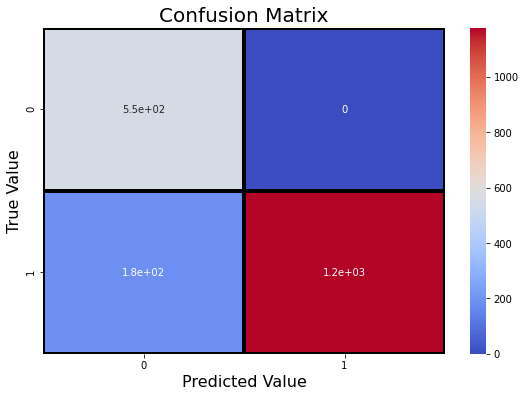

In [40]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'bert','nb')

###RANDOM FOREST-TFIDF

************ RF Classifier ***** tfidf ************
Mean Absolute Error:0.0
R Square: 1.0
Recall:  1.0
Precision:  1.0
Fl score:  1.0



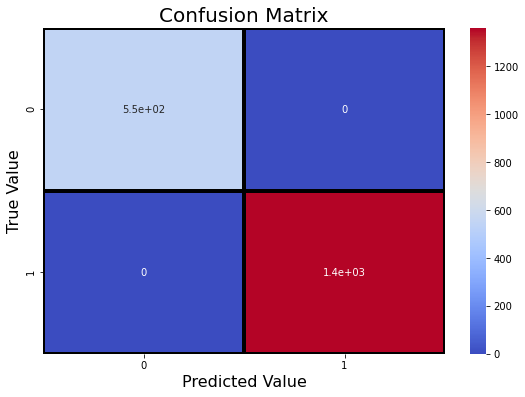

In [41]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'tfidf','rf')

###RANDOM FOREST-W2V

100%|██████████| 1914/1914 [02:01<00:00, 15.76it/s]


************ RF Classifier ***** w2v ************
Mean Absolute Error:0.0
R Square: 1.0
Recall:  1.0
Precision:  1.0
Fl score:  1.0
Best Estimators are {'max_features': 'sqrt', 'n_estimators': 100}



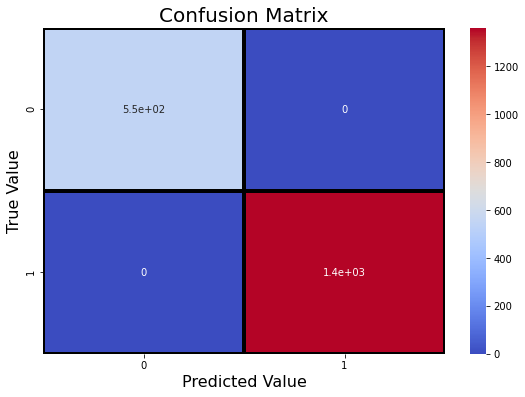

In [48]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'w2v','rf')

###RANDOM FOREST-FAST

100%|██████████| 1914/1914 [00:19<00:00, 100.03it/s]


************ RF Classifier ***** fast ************
Mean Absolute Error:0.0
R Square: 1.0
Recall:  1.0
Precision:  1.0
Fl score:  1.0



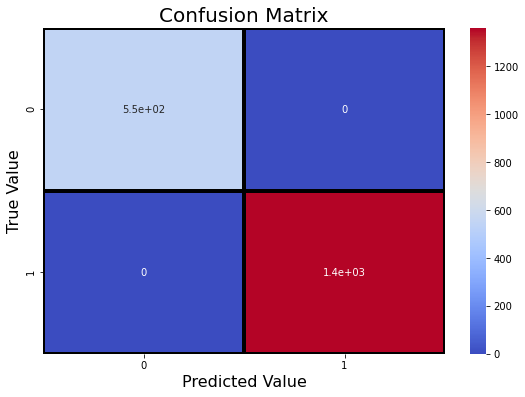

In [43]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'fast','rf')

###RANDOM FOREST-BERT

100%|██████████| 1914/1914 [02:20<00:00, 13.58it/s]


************ RF Classifier ***** bert ************
Mean Absolute Error:0.0
R Square: 1.0
Recall:  1.0
Precision:  1.0
Fl score:  1.0



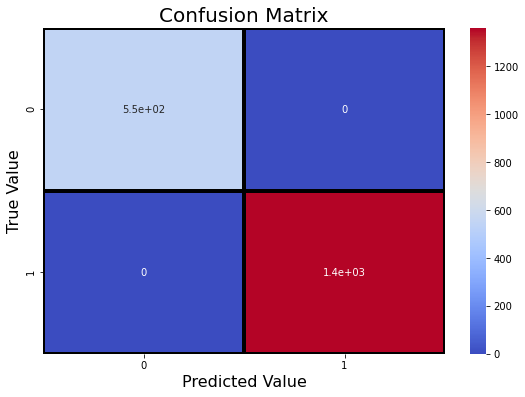

In [44]:
mod_models((samp_train,samp_train_y),(samp_test,samp_test_y),'bert','rf')

We can see that random forest is giving the best result so we will go with random forest and Word2Vec

##Best model 

In [32]:
my_model = RandomForestClassifier(max_features= 'sqrt', n_estimators= 100)

In [28]:
num_attrib=['category','sub_category1','sub_category2','business_service','urgency','impact','title_count','body_count','length']
        
train_num=train_x.filter(num_attrib)
test_num=test_x.filter(num_attrib)
model_num=pickle.load(open('/content/drive/MyDrive/dataset_link/minmax_scale_cs2_new_1.pkl','rb'))
train_num=model_num.transform(train_num)
test_num=model_num.transform(test_num)

train_text=train_x['all']
test_text=test_x['all']
train_txt,test_txt =vect_models(train_text, test_text, 'w2v')

train_df=pd.concat([pd.DataFrame(train_txt), pd.DataFrame(train_num,columns=num_attrib)], axis=1)
test_df=pd.concat([pd.DataFrame(test_txt), pd.DataFrame(test_num,columns=num_attrib)], axis=1)

100%|██████████| 9568/9568 [07:38<00:00, 20.87it/s]


In [33]:
my_model.fit(train_df,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
predictions = my_model.predict(test_df)


In [37]:
len(predictions)

9568

************ KNN Classifier ***** w2v ************
Mean Absolute Error:0.0
R Square: 1.0
Recall:  1.0
Precision:  1.0
Fl score:  1.0



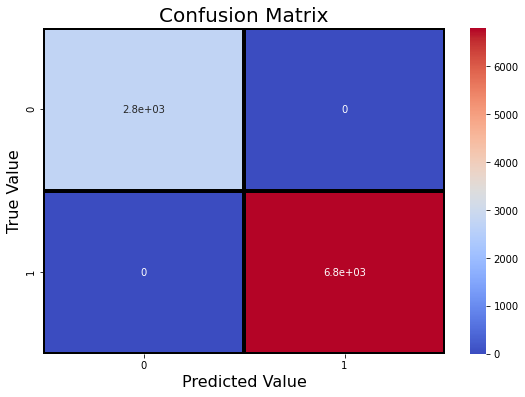

In [36]:
resultant(test_y, predictions,model="KNN Classifier",vect='w2v')